# COMP47670 Assignment 2: Flight Delay Analysis
This notebook contains all tasks associated with COMP47670 Data Science in Python Assignment 2.

## Task 1: Data Preperation & Characterisation 

### Dataset Combination

In [1]:
# Import Necessary Libraries
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# Load Flight Data into a pandas DataFrame
scheduled_flights_info = pd.read_csv("data/flights_schedule.csv")
# Load weather conditions into a pandas DataFrame
weather_condition_df = pd.read_csv("data/flight_conditions_outcomes.csv")
# Merge the two dataframes on "flight_id" column
flight_info_df = pd.merge(weather_condition_df, scheduled_flights_info, how="inner", on="flight_id")

### Data Cleaning
For each column in the DataFrame lets:
- Verify input is uniform.
- Convert to an appropriate data type.

In [3]:
# Print datatypes for each dataframe column.
flight_info_df.dtypes

flight_id         object
precipitation     object
wind              object
dep_delay          int64
flight_date       object
sched_dep_time    object
sched_arr_time    object
carrier_code      object
carrier           object
flight_number     object
origin            object
origin_name       object
origin_city       object
origin_country    object
dest              object
dest_name         object
dest_city         object
dest_country      object
distance_km        int64
aircraft_type     object
dtype: object

#### flight_id
This is the unique identifier for each flight in the dataset. Each entry should be stored as a string data type.

In [4]:
# Convert all entries to a string data type
flight_info_df["flight_id"] = flight_info_df["flight_id"].astype("string")

#### precipitation
This column contains categorical data refering to the precipitation on the day of each flight. Entries in this column take the following format:
- "Dry"
- "Light"
- "Moderate"
- "Heavy"

Since these categories have a natural order of precipitation intensity, lets convert entries to the following:

- Dry -> 0
- Light -> 1
- Moderate -> 2
- Heavy -> 3

In [5]:
# Define a precipitation mapping dictionary
precipitation_mapping = {"Dry" : 0, "Light": 1, "Moderate": 2, "Heavy" : 3}

# Apply the precipitation mapping dictionary.
flight_info_df["precipitation"] = flight_info_df["precipitation"].map(precipitation_mapping)

#### wind
This column contains categorical data regarding the wind on the day of each flight. Lets perform the same preprocessing as the "precipitation" column. Entries in the column are of the following format:
- Calm
- Breezy
- Windy
- VeryWindy
  
Since there is a natual order of wind intensity lets convert entries to the following:
- Calm -> 0
- Breezy -> 1
- Windy -> 2
- VeryWindy -> 3 

In [6]:
# Define a wind intensity mapping dictionary
wind_intensity_mapping = {"Calm" : 0, "Breezy" : 1, "Windy" : 2, "VeryWindy" : 3}

# Apply mapping dictionary
flight_info_df["wind"] = flight_info_df["wind"].map(wind_intensity_mapping)

#### dep_delay

This column contains the departure delay of each flight in minutes. Entries in this column are already of data type int so no preprocessing is required.

In [7]:
flight_info_df["dep_delay"].dtype

dtype('int64')

#### flight_date, sched_dep_time, sched_arr_time

Lets merge flight_date and sched_dep_time into a new column called scheduled_departure which is will be populated with DateTime objects. Lets also merge flight_date  with sched_arr_time into a new column called scheduled_arrival which is will be populated with DateTime objects. 

It's important to note that if a flight takes of before midnight and lands after it we will need to add 1 day to the entry in the scheduled_arrival column.

In [9]:
# Create departure datetime
departure_dt = pd.to_datetime(
    flight_info_df["flight_date"] + " " + flight_info_df["sched_dep_time"],
    format="%Y-%m-%d %H:%M",
    errors="coerce"
)

# Create arrival datetime (initially same date)
arrival_dt = pd.to_datetime(
    flight_info_df["flight_date"] + " " + flight_info_df["sched_arr_time"],
    format="%Y-%m-%d %H:%M",
    errors="coerce"
)

# Correct overnight flights
arrival_dt_corrected = arrival_dt.where(arrival_dt >= departure_dt, arrival_dt + pd.Timedelta(days=1))

# Save to dataframe
flight_info_df["scheduled_departure"] = departure_dt
flight_info_df["scheduled_arrival"] = arrival_dt_corrected


The columns flight_date, sched_dep_time, and sched_arr_time are now no longer needed, so lets remove them from our dataframe.

In [10]:
# Define a list of columns to drop
columns_to_drop = ["flight_date","sched_dep_time","sched_arr_time"]

# Drop the columns from the dataframe
flight_info_df = flight_info_df.drop(columns_to_drop, axis=1)

#### carrier_code

This column contains the a two digit code representing the airline operating each flight in the dataset. This column is redundent since the column "carrier_code" also exists in the dataframe representing the airline operating each flight. Lets now drop the "carrier_code" column from the dataframe.

In [11]:
# Drop column from the DataFrame
flight_info_df = flight_info_df.drop("carrier_code", axis=1)

#### carrier

This column represents the airline operating each flight in the dataset. Lets convert all entries to a string data type.

In [12]:
# Convert entries to a string data type 
flight_info_df["carrier"] = flight_info_df["carrier"].astype("string")

#### flight_number

This column contains identification information about each flight in the dataset. Since this column is not a unique identifier for each flight, this descriptive feature doesn't serve any purpose in the context of predicting flight delays. Lets nows remove this column from our DataFrame.

In [13]:
# Drop column from the DataFrame
flight_info_df = flight_info_df.drop("flight_number", axis=1)

#### origin

This column contains information about the origin of each flight in the dataset. Each entry is a three letter code perpresenting the city the flight departs from. The column "origin_name" already exists in the dataframe and is comprised of a more complete description of origin location. Since we have two columns describing the same thing lets remove the "origin" column in favour of the "origin_name" column. 

In [14]:
# Drop column from the DataFrame
flight_info_df = flight_info_df.drop("origin", axis=1)

#### origin_name

This column contains descriptive information about the origin airport of each flight in the dataset. Lets convert each entry into a string data type.

In [15]:
# Convert entries to a string data type
flight_info_df["origin_name"] = flight_info_df["origin_name"].astype("string")

#### origin_city

This column contains descriptive information about the origin city of each flight in the dataset. Lets convert each entry into a string data type.

In [16]:
# Convert entries to a string data type
flight_info_df["origin_city"] = flight_info_df["origin_city"].astype("string")

#### origin_country

This column contains descriptive information about the origin county of each flight in the dataset. Lets convert each entry into a string data type.

In [17]:
# Convert entries to a string data type
flight_info_df["origin_country"] = flight_info_df["origin_country"].astype("string")

#### dest

This columns is similiar to the "origin" column that was removed earlier. This column contains a three letter description of the destination of each flight in the dataset. It is safe to remove this column in favour of the "dest_name" column which provides a richer description of destination location.

In [18]:
# Drip "dest" column from the dataframe
flight_info_df = flight_info_df.drop("dest",axis=1) 

#### dest_name

This column provides a description of the destination airport of each flight in the dataset. Lets convert each entry to a string data type.

In [19]:
# Convert entries to a string data type
flight_info_df["dest_name"] = flight_info_df["dest_name"].astype("string")

#### dest_city

This column provides a description of the destination city of each flight in the dataset. Lets convert each entry to a string data type.

In [20]:
# Convert entries to a string data type
flight_info_df["dest_city"] = flight_info_df["dest_city"].astype("string")

#### dest_country

This column provides a description of the destination country of each flight in the dataset. Lets convert each entry to a string data type.

In [21]:
# Convert entries to a string data type
flight_info_df["dest_country"] = flight_info_df["dest_country"].astype("string")

#### distance_km

This column provides a description of the distance of each flight in the dataset in kilometers. Each entry is already converted to an integer data type so no preprocessing is necessary for this column.

In [79]:
flight_info_df["distance_km"].dtype

dtype('int64')

#### aircraft_type

This column provides a categorical description of the aircraft type of each flight in the dataset. Lets convert each entry to a string data type.

In [22]:
# Convert entries to a string data type
flight_info_df["aircraft_type"] = flight_info_df["aircraft_type"].astype("string")

### Derived Features

Now that the original dataset has been preprocessed, it is important to derive features that will enhance the classification algorithms analysis. This section will outline a number of derived features that will be added to the dataframe and why they will be useful.

#### 1. Binary Classification of Delay

Lets assume any flight with a value of "dep_delay" >= 15 to be delayed. Lets create a binary classification for this outcome and add it to the dataframe.

In [23]:
# Create a new column called "delayed".
# If the value for "dep_delay" >= 15 then the flight will be classified as delayed.
# A value of 1 will be added to the "delayed" column.

# If the value for "dep_delay" < 15 then the flight will be classified as not delayed.
# A value of 0 will be added to the "delayed" column.

flight_info_df["delayed"] = (flight_info_df["dep_delay"] >= 15).astype(int)

####  2. Time-Based Features from Scheduled Departures

My intuition leads me to believe that time of day, day of the week, and possible month of the year could be strong predictors of delays. Lets create 3 new columns:
- departure_hour
- departure_day
- departure_month

In [24]:
# Create new column with the hour of day for the scheduled departure.
flight_info_df["departure_hour"] = flight_info_df["scheduled_departure"].dt.hour

# Create new column with the day of week for the scheduled departure.
flight_info_df["departure_dayofweek"] = flight_info_df["scheduled_departure"].dt.dayofweek

# Create new column with the month of year for the scheduled departure.
flight_info_df["departure_month"] = flight_info_df["scheduled_departure"].dt.month

#### 3. Flight Duration

Lets compute the flight duration in minutes and add it as its own column to the dataframe.

In [25]:
# Handle next-day arrivals
arrival_adjusted = flight_info_df["scheduled_arrival"].where(
    flight_info_df["scheduled_arrival"] >= flight_info_df["scheduled_departure"],
    flight_info_df["scheduled_arrival"] + pd.Timedelta(days=1)
)

# Calculate flight duration in minutes
flight_info_df["flight_duration_mins"] = (
    (arrival_adjusted - flight_info_df["scheduled_departure"])
    .dt.total_seconds() / 60
)

#### 4. Weather Condition Encoding

It might also be useful to add a "bad_weather" flag. Lets say the weather is "bad" if the precipitation level or wind level is greater than or equal to 2. 

In [26]:
# If the values in the "precipitation" or "wind" columns are >= 2 then the "bad_weather" flag will
# be set to 1, 0 otherwise.

flight_info_df["bad_weather"] = ((flight_info_df["precipitation"] >= 2) |
                                 (flight_info_df["wind"]  >= 2)).astype(int)

#### 5. Origin Flight Count

Lets add the total number of flight that are scheduled to depart from the departure airport for each flight in the dataset.

In [27]:
# Add a flight count column per departure airport
flight_info_df["origin_flight_count"] = flight_info_df.groupby("origin_name")["flight_id"].transform("count")

#### 6. Peak Traffic Indicators

Lets define the peak traffic times as 6-9 am and 4-7 pm and add a binary classification category to the dataframe.

In [28]:
# Set the new peak_hour_departure column to 1 if the flight schedules to depart between 6-9 am
# or 4-7 pm, 0 otherwise.

flight_info_df["peak_hour_departure"] = ((flight_info_df["departure_hour"].between(6,9)) | 
                                         (flight_info_df["departure_hour"].between(16,19))).astype(int)


### Data Characterisation

This section will explore and describe the dataset before we begin to apply our classification algorithms. This section will be broken down into the following sections:
- Dataset Overview
- Target Feature Distributions
- Visualisation
- Trends and Observations
- Future Modelling Work

#### Dataset Overview

We now have a dataframe containing the following features:
- **flight_id** - A unique identifier for each flight in the dataset
- **precipitation** - A numeric range of values representation precipitation intenstiy from 0-3
- **wind** - A numeric range of values representation wind intenstiy from 0-3
- **dep_delay** - The departure delay in minutes
- **carrier** - Flight Operator
- **origin_name** - Name of departure airport
- **origin_city** - Name of departure city
- **origin-country** - Name of departure country
- **dest_name** - Name of destination airport
- **dest-city** - Name of destination city
- **dest-country** - Name of destination country
- **scheduled_departure** - DateTime object representing the scheduled departure date and time
- **scheduled_arrival** - DateTime object representing the scheduled arrival date and time
- **delayed** - Binary classification if the flight suffered a delayed departure (> 15 mins past scheduled departure time)
- **departure_hour** - The 24 hour clock representation of the scheduled hour of departure
- **departure_dayofweek** - An integer representation of day of departure (0 for Monday, 1 for Tuesday, etc..)
- **departure_month** - An integer representation of month of departure (0 for January, 1 for February, etc..)
- **flight_duration_mins** - Flight duration in minutes
- **bad_weather** - A binary representation of if the flight suffered from bad weather (1 == true, 0 == false). A flight suffered from "bad weather" if either the wind or precipitation levels were >= 2. 
- **origin_flight_count** - The total number of flights in the dataser that departed from the flights airport.
- **peak_hour_departure** - A binary representation of if the flight departed during "peak hours". A flight is said to have departed during peak hours if the flights scheduled departure was between 6-9 am or 4-7 pm.

#### Target Feature Distribution

This section will discuss how the target feature (departure delays) is distributed in the dataset.

##### Count Plot

Lets define a count plot to show the number of delayed and non delayed flights in the dataset.

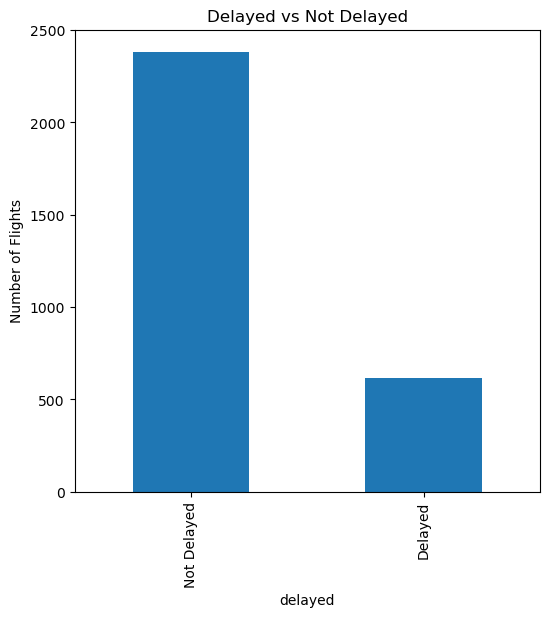

In [29]:
# Define plot characteristics
flight_info_df["delayed"].replace({0: "Not Delayed", 1: "Delayed"}).value_counts().plot(
    kind="bar",
    figsize=(6, 6),
    ylabel="Number of Flights"
)

# Define plot labels
plt.title("Delayed vs Not Delayed")
plt.show()

##### Pie Chart

Lets create a pie chart to visualise the percentage of delayed and not delayed flights in the dataset. This will provide an overview of the distribuition of the target variable in the dataset.

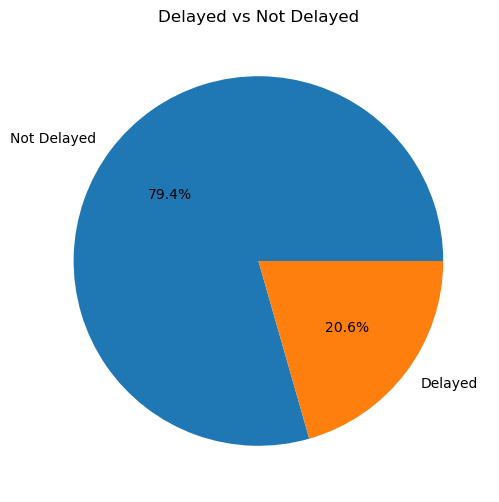

In [30]:
# Define plot characteristics
flight_info_df["delayed"].replace({0: "Not Delayed", 1: "Delayed"}).value_counts().plot(
    kind="pie",
    autopct="%1.1f%%",
    figsize=(6, 6),
    ylabel=""
)

# Define plot labels
plt.title("Delayed vs Not Delayed")
plt.show()

##### Target Feature Distribution Trends 

The dataset shows a 79.4-20.6 split between non-delayed and delayed flights. This shows a moderate class imbalance, with the vast majority of flights departing on time. While this class imbalance is reflective of the aviation industry, it will have implications on model evaluation. A naive classification model predicting all flights as "not delayed" would achive 80% accuracy. This means that accuracy alone is not a sufficient performance metric and other forms of model evaluation should be used. The class imbalance also suggest models may naturally favour the majority class unless properly regularised or evaluated with appropriate metrics.

#### Visualisations

This section will visualise the important trends in the flight dataset.

##### Departure Delay Duration

Lets create a histogram to visualise the duration of each delayed flight.

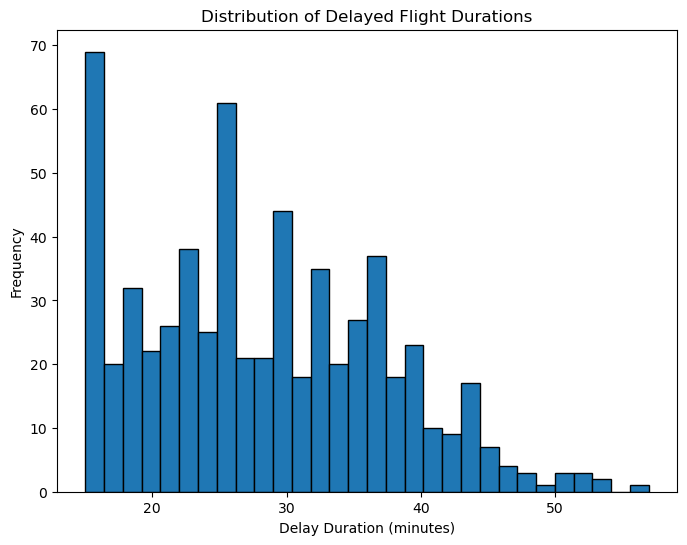

In [31]:
# Departure Delay histogram plot
delays = flight_info_df[flight_info_df["delayed"] == 1]["dep_delay"]

# Define plot characteristics
delays.plot.hist(
    bins=30,
    figsize=(8,6),
    edgecolor="black"
)

# Define plot labels
plt.title("Distribution of Delayed Flight Durations")
plt.xlabel("Delay Duration (minutes)")
plt.ylabel("Frequency")
plt.show()

###### Key Trends

- **Right Skewed Distribution**: Most  delayed flights experience short delays (15-30 mins), with the frequency decreasing steadly as delay duration increases.
- **Long-Tail Behaviour**: A smaller number of flights experience significantly longer delays (40-60 mins).
- **High Density near the Minimum Delay Threshold**: The largest bar appears near 15 mins, which alligns with the project brief's definition of a "delay".

###### Interpretations

This indicates that while delays do happen, they tend to be short in duration, and extreme delays are less common.

##### Flight Distance

Lets create a histogram to visualise the length of each flight in the dataset.

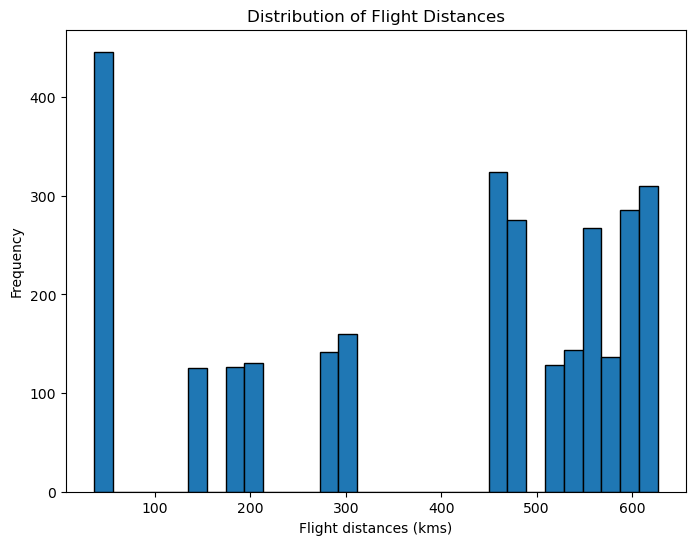

In [32]:
# Flight Distance scatter plot
flight_distances = flight_info_df["distance_km"]

# Define plot characteristics
flight_distances.plot.hist(
    bins=30,
    figsize=(8,6),
    edgecolor="black"
)
# Define plot labels
plt.title("Distribution of Flight Distances")
plt.xlabel("Flight distances (kms)")
plt.ylabel("Frequency")
plt.show()

###### Key Trends

- **Multimodal Distribution**: The plot shows distinct clusters around certain distance ranges. This is unsurprising since the dataset only contains flight data from flight between Ireland and The United Kingdom.
- **Large Spike at the Shortest Distance Bin**: A very high count appears around the smallest distance group (50-75 kms), suggest heavy traffic on at least one short hall route.
- **Even Distribution in Long-Range Distance**: Distances in the 450-650 km range appear evenly spread with no single dominant value.

###### Interpretations
Flight operations in this dataset include a mix of distance ranges, with one particular short-haul route dominating traffic volume.

##### Flight Durations

Lets create a histogram to visualise the duration of each flight in minutes.

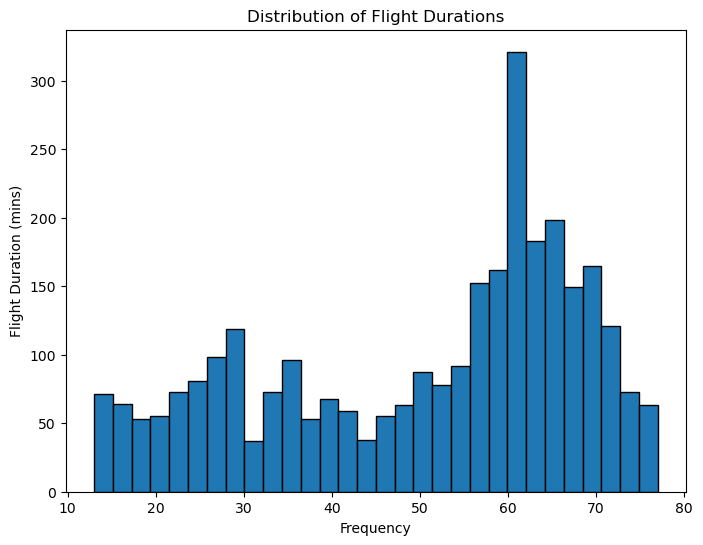

In [33]:
# Flight Duration scatter plot
flight_duration = flight_info_df["flight_duration_mins"]

# Define plot characterists
flight_duration.plot.hist(
    bins=30,
    figsize=(8,6),
    edgecolor="black"
)

# Define plot labels
plt.title("Distribution of Flight Durations")
plt.xlabel("Frequency")
plt.ylabel("Flight Duration (mins)")
plt.show()

###### Key Trends

- **Multimodal Structure**: The histogram shows clusters, indicating different categories of flights (Short and medium-haul). This correlates with the earlier distance distributions.
-  **Most distance fall between 50-75 minutes**: The bulk of flights appear to operate within a typical short and medium-haul time window.

###### Interpretation:
The dataset reflects a diverse selection of distances in the dataset.

##### Wind levels

Lets create a bar chart to visualise the number of each wind lever

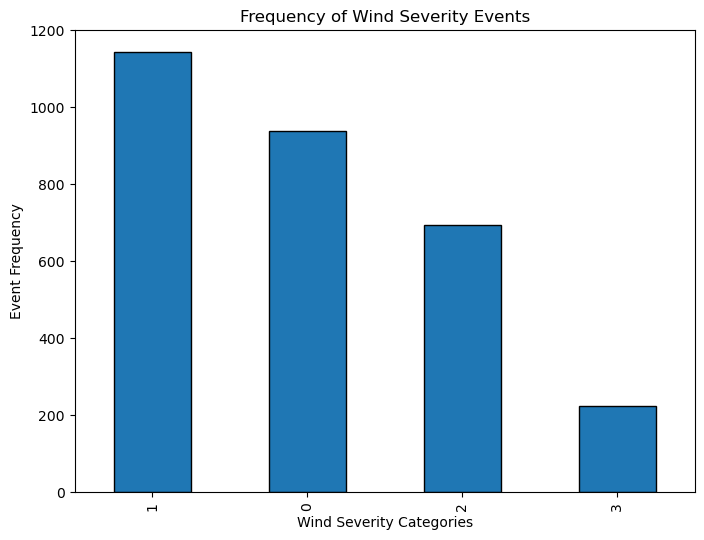

In [34]:
# Grab the number of occurances of each wind category
wind_level_counts = flight_info_df["wind"].value_counts()

# Define plot characterists
wind_level_counts.plot.bar(
    figsize=(8,6),
    edgecolor="black"
)

# Define plot labels
plt.title("Frequency of Wind Severity Events")
plt.xlabel("Wind Severity Categories")
plt.ylabel("Event Frequency")
plt.show()

###### Key Trends

- **Calm and Breezy conditions dominate**: Categories 0 (“Calm”) and 1 (“Breezy”) are the most frequent of the wind severity events.
- **Strong Wind Conditions are Rare**: Wind levels 2 and 3 (“Windy” and “Very Windy”) occur far less frequently.
- **Inverse Relationship**: As wind severity increases, the number of events decreases.

###### Interpretation:
Most flights experience normal wind conditions. This is typical for aviation data, where extreme weather is rare but important because it can significantly impact delays.

##### Precipitation Levels

Lets create a bar chart to visualise the frequency of precipitation severity events.

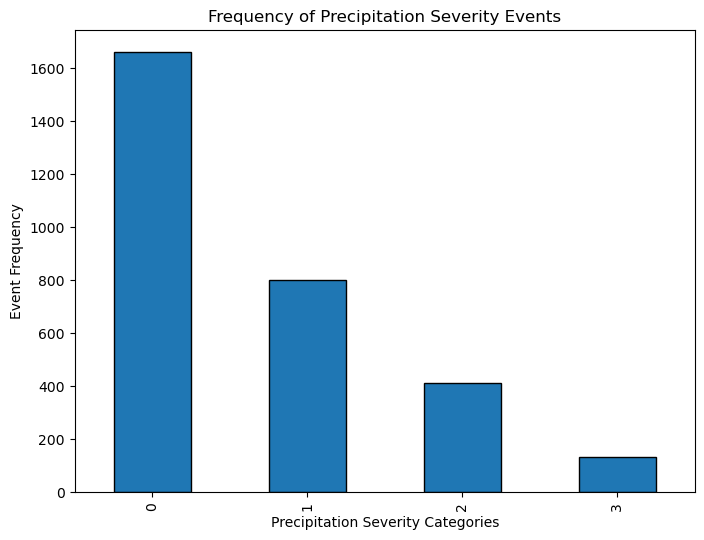

In [35]:
# Grab the number of occurances of each wind category
wind_level_counts = flight_info_df["precipitation"].value_counts()

# Define plot characterists
wind_level_counts.plot.bar(
    figsize=(8,6),
    edgecolor="black"
)

# Define plot labels
plt.title("Frequency of Precipitation Severity Events")
plt.xlabel("Precipitation Severity Categories")
plt.ylabel("Event Frequency")
plt.show()

###### Key Trends

- **Dry Conditions dominate**: Precipitation level 0 accounts for the majority of observations.
- **Light Precipitation still Common**: Levels 1 and 2 appear noticeably but far less than 0.
- **Heavy Precipitation is Rare**: Level 3 has a very small count compared to others.


###### Interpretation

This distribution shows that **most flights operate under favourable weather**, with severe precipitation being uncommon. However, the rarer high-severity events are operationally important because they often correlate with higher delay rates.


##### Hour of Departure Delays

Lets create a histogram to visualise the frequency of departure delays per hour in the dataset.

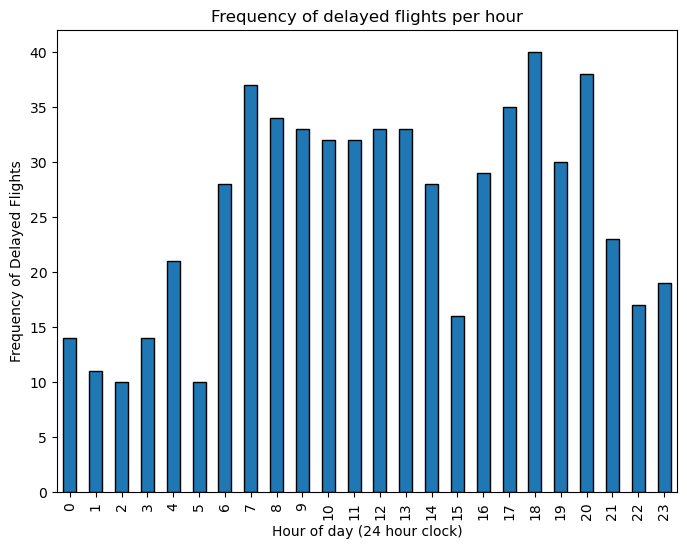

In [100]:
# Select just delayed flight
delayed_flight_df = flight_info_df.loc[flight_info_df["delayed"] == 1]

# Count the frequency of delayed flights per hour
frequency_per_hour_of_delayed_flights = delayed_flight_df["departure_hour"].value_counts()

# Sort the returned series based on the index of the series (hour of day)
frequency_per_hour_of_delayed_flights = frequency_per_hour_of_delayed_flights.sort_index()

# Define a bar chart to display the frequency of delayed flights per hour
frequency_per_hour_of_delayed_flights.plot.bar(
    figsize=(8,6),
    edgecolor="black"
)

# Define plot labels
plt.title("Frequency of delayed flights per hour")
plt.xlabel("Hour of day (24 hour clock)")
plt.ylabel("Frequency of Delayed Flights")
plt.show()

##### Key Trends
- **Low Frequency between 0-5**
- **High Frequency between 7am - 2pm**
- **Low Frequency at 3pm**
- **High Frequency between 4pm - 8pm**
- **Low Frequency from 9pm - midnight**

##### Interpretation

There are two identifiable periods 7 - 13 and 16 - 20 that have a higher frequency of delays. This periods extend longer that originally hypothesises (6-9 am and 4-7 pm). 

**Change peak_hour_departure column**

Lets alter the entries in the "peak_hour_departure" column to represent this new trend.

In [102]:
# Change the peak_hour_departure column to 1 if the flight schedules to depart between 7am -2 pm
# or 4-8 pm, 0 otherwise.

flight_info_df["peak_hour_departure"] = ((flight_info_df["departure_hour"].between(7,14)) | 
                                         (flight_info_df["departure_hour"].between(16,20))).astype(int)


###### Key Trends

- High delay frequencies between 6:00 - 14:00 and 16:00 - 20:00
- Low delay frequencies between 0:00 - 5:00 and 15:00 - 15:59 and 21:00 - 23:00

###### Interpretation

The hour period of high departure delays was originally hyothesised to be between 6-9 and 16-19 pm. This period needs to be extended from 6:00 - 14:00 and 16:00 - 20:00.

In [104]:
# Lets alter the peak_hour_departure column has been altered so entries are 1 if 
# the flight is scheduled to depart between 6:00-14:00 or 16:00-20:00, 0 otherwise.

flight_info_df["peak_hour_departure"] = ((flight_info_df["departure_hour"].between(6,14)) | 
                                         (flight_info_df["departure_hour"].between(16,20))).astype(int)


##### Day of Departure Delays

Lets create a histogram to visualise the frequency of departure delays per day in the dataset.

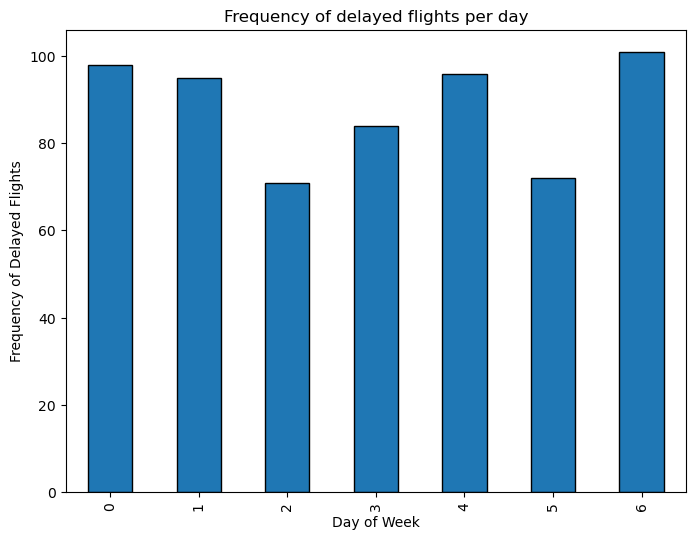

In [101]:
# We can reuse the delayed_flight_df variable from before
delay_frequency_per_day = delayed_flight_df["departure_dayofweek"].value_counts()

# Sort based on the index 1-7 (day of the week)
delay_frequency_per_day = delay_frequency_per_day.sort_index()

# Define Plot
delay_frequency_per_day.plot.bar(
    figsize=(8,6),
    edgecolor="black"
)

# Define plot labels
plt.title("Frequency of delayed flights per day")
plt.xlabel("Day of Week")
plt.ylabel("Frequency of Delayed Flights")
plt.show()

###### Key Trends

Mondays, Tuesdays, Fridays and Sundays have the highest frequency of delays (95-101 range) while Wednesdays, Thursdays and Saturdays have a slightly lower rate (71-84 range).

Lets add a column called "peak_day_departure" that represents if a flight is scheduled to depart on a busy day.

In [107]:
# Create a new peak_day_departure column and set entries to 1 if the flight is scheduled to depart on a "busy day"
# (Mondays, Tuesdays, Fridays and Sundays) or 0 if the flight is scheduled to depart on a "quiet day"
# (Wednesdays, Thursdays and Saturdays)

flight_info_df["peak_day_departure"] = ((flight_info_df["departure_dayofweek"].between(0,1)) | 
                                         (flight_info_df["departure_dayofweek"].eq(4)) | 
                                         (flight_info_df["departure_dayofweek"].eq(6))                                       
                                       ).astype(int)

##### Month of Departure Delays

Lets create a histogram to visualise the frequency of departure delays per month in the dataset.

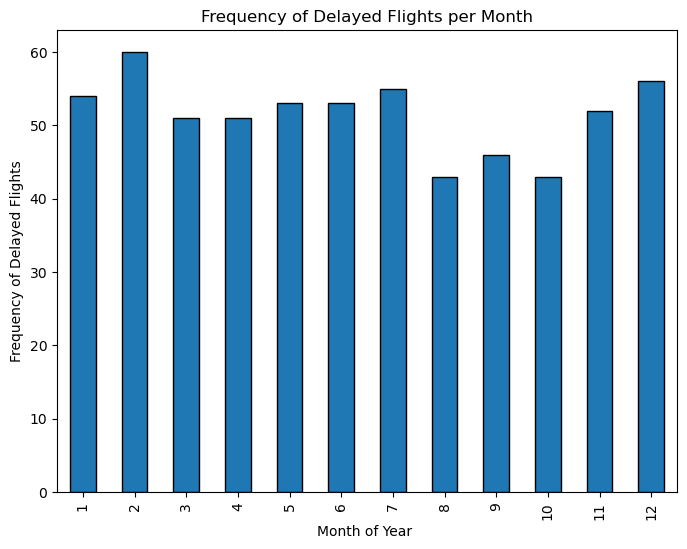

In [98]:
# We can reuse the delayed_flight_df variable from before
delay_frequency_per_month = delayed_flight_df["departure_month"].value_counts()

# Sort the returned series based on the index of the series (Month of Year)
delay_frequency_per_month = delay_frequency_per_month.sort_index()

# Define a bar chart to display the frequency of delayed flights per month
delay_frequency_per_month.plot.bar(
    figsize=(8,6),
    edgecolor="black"
)

# Define plot labels
plt.title("Frequency of Delayed Flights per Month")
plt.xlabel("Month of Year ")
plt.ylabel("Frequency of Delayed Flights")
plt.show()

###### Key Trends

Surprisingly there is now trend in the frequency of delayed departures per month.

###### Interpretation

Delay frequency per month fluctuate from a minimum of 43 in August to 60 in February. This range is too small to justify adding new derived features to the dataframe.

##### Overall Interpretaion

Across all visualisations, the data shows:
- Most flight operate under normal weather conditions.
- Delays tend to be short, with only a minority experiencing significant delays.
- The dataset contains multiple routes.
- Severe weather is rare, but their influence on operations may become highly predictive in later analysis.
- Flights are more likely to be delayed between 6:00 - 14:00 and 16:00 - 20:00.
- Flights are more likely to be delayed on Mondays, Tuesdays, Fridays and Sundays.

#### New Derived Features

The following Features have either been altered or added to the "flight_info_df" following the **Visualisation** Section above:
- The **peak_hour_departure** column has been **altered** so entries are 1 if the flight is scheduled to depart between 6:00-14:00 or 16:00-20:00, 0 otherwise.
- The new **peak_day_departure** column was **created** and sets entries to 1 if the flight is scheduled to depart on a "busy day" (Mondays, Tuesdays, Fridays and Sundays) or 0 if the flight is scheduled to depart on a "quiet day" (Wednesdays, Thursdays and Saturdays)

#### Future Modelling Work

This section will connect the observed trends to later classification work to be done.

##### Analysis for Future Modelling Work

The trends observed during data characterisation provide several insights that will guide the upcoming classification tasks. First, the moderate imbalance in the target variable (with roughly 80% of flights not delayed and 20% delayed) indicates that relying solely on accuracy of results would be a misleading form of evaluation. Instead, metrics such as precision, recall, F1-score, and ROC–AUC could be used to assess how effectively the models detect delayed flights.

The distributional patterns in flight durations and distances suggest that the dataset contains multiple types of routes (short-haul and medium-haul flights). These differences mean that features such as flight distance, scheduled duration, and route identifiers will likely carry predictive power. Their multimodal distributions also suggest that non-linear models (e.g. random forests) may capture these patterns more effectively than purely linear models.

Weather variables exhibit strong asymmetry, with the majority of flights operating in calm or dry conditions and only a small proportion encountering severe weather. Although rare, these high-severity events are likely to have a disproportionate impact on delays. This supports including derived features such as wind_level, precip_level, and the bad_weather flag in the predictive models. Their clear trends in the EDA suggest that they may become some of the most influential predictors in the feature importance analysis later on.

The analysis of delay durations showed a right-skewed distribution, with many delays clustering just above the 15-minute threshold. This implies that the classification task may involve distinguishing borderline delays from on-time flights—a scenario where probabilistic models like logistic regression can be particularly useful due to their calibrated output probabilities.

Finally, airport- and carrier-level variations (e.g., busiest airports showing more delays or specific carriers exhibiting better on-time performance) point to the value of engineered features such as airport traffic counts, average carrier delay, and route-level encodings. These aggregated features will allow the models to capture structural tendencies in the data that individual per-flight variables might miss.

Overall, the trends observed in the characterisation phase strongly motivate the choice of features and models for the classification tasks. They highlight the need for a combination of interpretable models (e.g. logistic regression) and more flexible non-linear models (e.g. random forests or gradient boosting) to effectively capture both linear relationships and more complex interactions present in the data. This EDA therefore forms a foundation for designing an informed and effective modelling strategy in the subsequent stages of the assignment.

## Task 2: Classification & Evaluation

In [36]:
# Lets quickly import all the necessary libraries to create and evaluate the classification algorithms
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.inspection import permutation_importance

### Classification Algorithm 1: Linear Regression Classification

**In**troduction to Linear Regression

Lets begin briefly with a description of the Linear Regression Classification algorithm and how it cam be applied to the dataset to predict departure delays. 

##### What is Linear Regression

Linear regression is a statistical method used to model the relationship between a dependent variable and one or more independent variables by fitting a straight line to the data. Linear Regression assmumes (while never being the case) a linear relationship between the dependent variable, and the one or more independent variables, meaining that as the independent variable(s) change, the dependent variable changes in a predictable, straight-line manner. The model's goal is to find the line that best represents the data, allowing for predictions about the dependent variable based on the values of the independent variables.

In the case of this task, linear regression can be used to predict the departure delay (dependent variable) based on one or more independent variables. Lets now determine the independent variables to be used in the linear regression model.

In [112]:
# Define a list of features to use in the linear regression classifier.
feature_columns = [
    "distance_km",
    "flight_duration_mins",
    "wind",
    "precipitation",
    "departure_hour",
    "departure_dayofweek",
    "departure_month",
    "peak_hour_departure",
    "peak_day_departure"
]


# Features
X = flight_info_df[feature_columns]

# Target Variable
y = flight_info_df["dep_delay"]

#### Splitting Data

In [113]:
# Split the dataset into training (80%) and testing (20%) sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Scale Numeric Features

In [114]:
# Initiate StandardScaler.
scaler = StandardScaler()

# Fit and transform the training data.
X_train_scaled = scaler.fit_transform(X_train)

# Transform test data
X_test_scaled = scaler.transform(X_test)

#### Train the Linear Regression Model

In [115]:
# Create a LinearRegression object.
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train_scaled, y_train)

LinearRegression()

#### Making Predictions

In [116]:
# Make predictions based on the testing data
y_pred = model.predict(X_test_scaled)

#### Linear Regression Evaluation

Lets now describe the evaluation metrics for a linear regression model and outline what they tell us about the performanace of the model.

##### MAE (Mean Absolute Error)

The mean absolute error of a linear regression model tells us the average of how much the model was wrong by. It is calculated by the following:

$\frac{1}{D}\sum_{i=1}^{D}|x_i-y_i|$

or in simpler terms:
$\frac{Sum Of The Absolute Errors}{Number Of Predictions}$


In [117]:
# Calculate the MAE of the Linear Regression Function.
mea = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mea:.4f}")

Mean Absolute Error: 8.1488


###### MAE Results Interpretation:

The test resulted in a $MEA = 8.3145$, meaning that on average the regression model predicted delays $\pm 8.3145$ the actual delay of each flight. This result is quite poor but is unsurprising given the unbalanced nature of the dataset.

##### RMSE (Root Mean Squared Error)

The RMSE of a model determines how well the predicted values from the model align with the actual observed values in the dataset. It is calculated by the following:

$\sqrt{\frac{1}{D}\sum_{i=1}^{D}(x_i-y_i)^2}$

or more simply:

$\sqrt{\frac{SumOfTheSquaredErrors}{NumberOfPredictions}}$

In [118]:
# Calculate and print RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
print(f"Root mean squared error: {rmse:.4f}")

Root mean squared error: 10.9784


###### RMSE Results Interpretation

$RMSE = 11.1817$ 

##### R-Squared $R^2$ Score

The R-Squared score compares the models performance against a baseline model that only predicts the mean of the target variable (departure delay in minutes in this case). The R-squared score can be calculated by the following:

$R^2 = 1-\frac{ResidualSumOfSquares}{TotalSumOfSquares}$

The following are interpretaions of $R^2$ scores:
- $R^2 = 1.0$  means a perfect model.
- $R^2 = 0$ means the model is no better that just predicting the mean delay.
- $R^2 < 0$ the model performs worse than predicting the mean.
- $0 < R^2 < 1$ the model explains some of the variance, but not all

In [119]:
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2:.4f}")

R-squared: 0.0539


###### R-Squared Result Interpretation

$R^2 =  0.0537$ very poor result, about 0.05% of predictions are more accurate than just predicting the mean delay of the flights.

#### View Scaled Coefficients

In [120]:
coef_scaled = pd.DataFrame({
    "Feature": feature_columns,
    "Coefficient (scaled)": model.coef_
}).sort_values(by="Coefficient (scaled)", ascending=False)

coef_scaled

,Feature,Coefficient (scaled)
2,wind,1.686421
3,precipitation,1.188646
7,peak_hour_departure,0.654982
8,peak_day_departure,0.297542
0,distance_km,0.255996
5,departure_dayofweek,0.177070
4,departure_hour,-0.092458
1,flight_duration_mins,-0.219956
6,departure_month,-0.277704


### Logistical Regression

**Introduction To Logistical Regression**

Linear regression as we have seen above performed poorly. Before progressing onto the second classifier algorithm lets take a Logistical Regression approach. Logistical regression is a statistical method for predicting binary classes (e.g "yes" or "no", "True" or "False" etc). Logistical Regression uses a sigmoid function that produces an "s" shaped curve that can take any real-valued number and map it to a value between 0 and 1. If the output of the sigmoid function is > 0.5, the outcome is classified as 1 or Yes, while if the output of the sigmoid function is < 0.5 then, the outcome is classified as 0 or No.

Since the Linear regression model performed poorly at predicting exact delays in minutes, lets apply a Logistical regression model to see if it can accuratly classify flights as delayed or not delayed.

#### Selecting Features

Lets define the features to use in the logistical regression model.

In [148]:
# Define the list of features to use in the Logistical Regression Model
logistical_regression_feature_columns = [
    "distance_km",
    "precipitation",
    "wind",
    "peak_hour_departure",
    "peak_day_departure"
]

#### Define Target Variable and Features

Let's now create two dataframes to represent the target variable and the features.

In [149]:
# Define the dataframe containing features
X = flight_info_df[logistical_regression_feature_columns]

# Define the dataframe containing the target variables.
y = flight_info_df.delayed

#### Splitting Data

Lets split the dataset into 80%, to be used to train the model, and 20%, to be used to test and evaluate the model. 

In [150]:
# Define a 80% training set and a 20% testing set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=16)

#### Scale values

In [151]:
# Initialise standard scaler
scaler = StandardScaler()

# Fit and Transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform test data
X_test_scaled = scaler.transform(X_test)

#### Model Development and Prediction

Lets now define and train the logistical regression model.

In [152]:
logistical_regression_model = LogisticRegression(max_iter=500)

logistical_regression_model.fit(X_train_scaled, y_train)

y_pred = logistical_regression_model.predict(X_test_scaled)

#### Logistical Regression Model Evaluation

Since logistical Regression predicts categorical data and not continuous data, the evaluation metrics used previously for the Linear Regression Model are no longer valid. Lets now describe the evaluation metrics for a Logistical Regression Model and detail what they tell us about the performanace of the model.

##### Precision

This metric calculates: "*When a model predicts a class, how often is it correct?*" Lets take the 0 class meaning the flight wasn't delayed, the precision metric tells us what percentage of those predictions were actually correct.

##### Recall

This metric calculates: "*Out of all the true cases of this class, how many did the model correctly find?*". For the delayed class *Recall measures how many of the actual delayed flights your model successfully detected*.

##### f1-score

This metric calculates: A balanced summary of precision and recall.

##### Support

How many actual samples exist for this class in the test set? If the support size is small, tben performance metrics become less reliable.

These four metrics can be easily calculated using the **classification_report(...)** method.

In [153]:
print("-------- Delay Classification report --------")
print(classification_report(y_test,y_pred))

-------- Delay Classification report --------
              precision    recall  f1-score   support

           0       0.78      0.99      0.87       466
           1       0.56      0.04      0.07       134

    accuracy                           0.78       600
   macro avg       0.67      0.51      0.47       600
weighted avg       0.73      0.78      0.69       600



##### Confusion Matrix

A confusion matrix shows how your classifier’s predictions compare to the actual truth. For delayed vs not delayed flights, it looks like this:

|                     | Predicted: NotDelayed | Predicted: Delayed |
| :----------------   | :------: | ----: |
| Actual: Not Delayed | True Negative         | False Positive     |
| Actual: Delayed     | False Negative        | True Positive      |

What do each each of the entries in the confusion matrix mean:
- **True Negative**: Flight was predicted not delayed and was actually not delayed.
- **False Negative**: Fligth was predicted not delayed but the flight was actually delayed.
- **True Positve**: Flight was predicted delayed and was delayed.
- **False Positive**: Flight was predicted delayed but was actually not delayed.

Lets now create a confusion matrix for the Logistical Regression classifier.

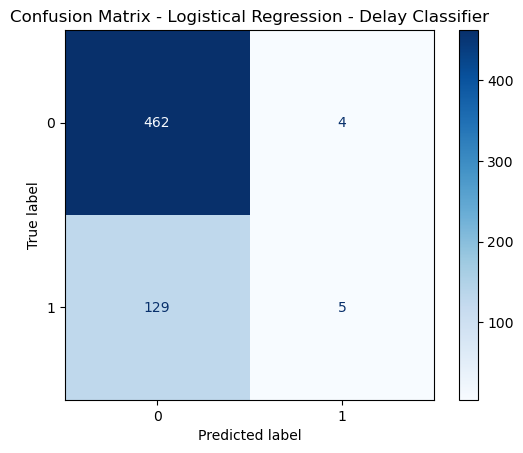

In [154]:
confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=logistical_regression_model.classes_)
target_names = ["No Delay", "Delay"]
confusion_matrix_display.plot(cmap="Blues")
plt.title("Confusion Matrix - Logistical Regression - Delay Classifier")
plt.show()

##### Confusion Matrix Analysis

Analysis here...

#### Feature Prediction Power

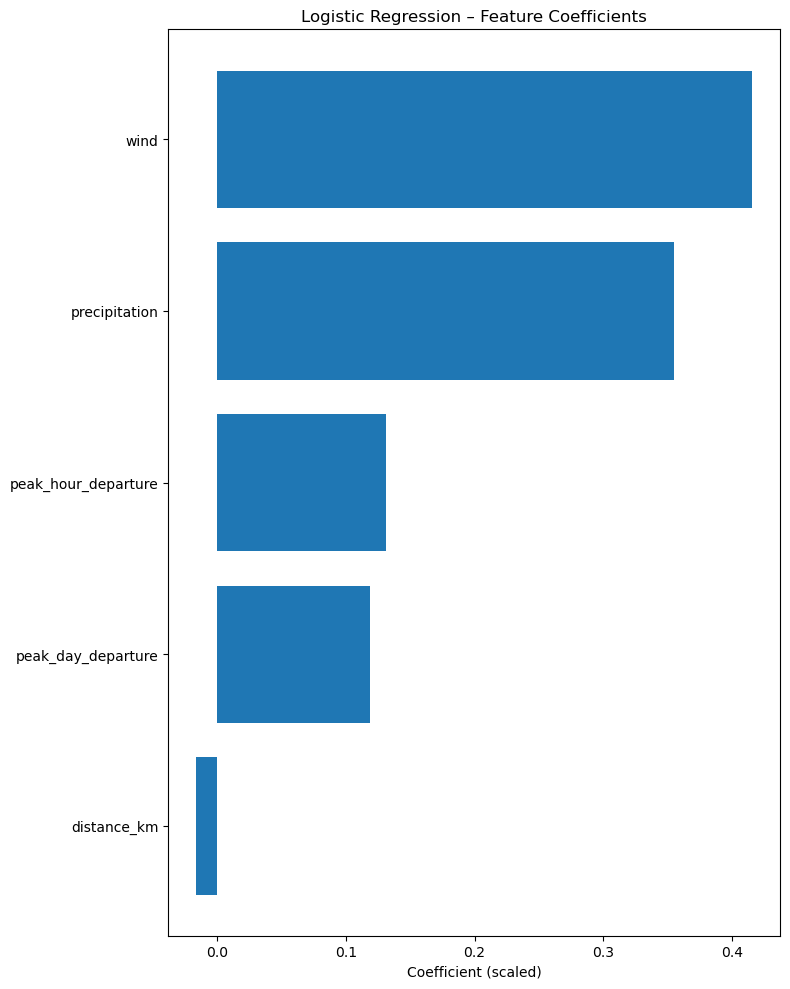

In [155]:
coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": logistical_regression_model.coef_[0]
}).sort_values("Coefficient", ascending=True)

plt.figure(figsize=(8, 10))
plt.barh(coef_df["Feature"], coef_df["Coefficient"])
plt.xlabel("Coefficient (scaled)")
plt.title("Logistic Regression – Feature Coefficients")
plt.tight_layout()
plt.show()

### Classification Algorithm 2: K-Nearest Neighbours (KNN) Classification

**Introduction To K-Nearest Neighbours**

K-Nearest Neighbours Classification is a supervised machine learning algorithm used for typically used for classification. It workd by finding the $K$ closed data points (neighbours) to a given input and makes a pridiction based on the majority class. K-Nearest Neighbours works by using proximity and majority voting to make predictions about an input. 

sklearn offers a *KNeighborsClassifier* package which follows the same processes as the linear and logistical regression models that have been performed previously.

####  Selecting Features

Lets select features from the dataset to use as input for the KNN classifer model. 

In [182]:
# Define the list of features to use in the KNN Model
feature_columns = [
    "wind",
    "precipitation",
    "bad_weather",
    "departure_dayofweek",
    "origin_flight_count",
    "peak_day_departure",
    "origin_flight_count"
]

#### Define Target Variable and Features

In [183]:
# Define X as a dataframe containing the features for the KNN classifier.
X = flight_info_df[feature_columns]

# Define the "delayed" column as the target variable we wish to predict.
y = flight_info_df["delayed"]

#### Splitting Data

In [184]:
# Lets split the dataset for training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

#### Scale Numeric Features

In [185]:
# Scale the features using a standard scaler object.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Train the KNN Model

In [187]:
# Define a KNN Classification Model with K = 5
knn = KNeighborsClassifier(n_neighbors=5)

# Fit the model to the training data.
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier()

#### Make Prediction using the Test Data  

In [188]:
# Use the KNN classifier to predict departure delays.
y_pred = knn.predict(X_test_scaled)

#### Model Evaluation

Since the KNN model is used for classification, lets use the same maetric as the Logistical Regression model namely:
- Precision
- Recall
- f1-Score
- Support
- Confusion Matrix
- Accuracy

##### Classification Report Evaluation

In [189]:
print("----------------- Delay Classification Report -----------------")
print(classification_report(y_test, y_pred))

----------------- Delay Classification Report -----------------
              precision    recall  f1-score   support

           0       0.81      0.93      0.86       477
           1       0.35      0.15      0.21       123

    accuracy                           0.77       600
   macro avg       0.58      0.54      0.54       600
weighted avg       0.71      0.77      0.73       600



Evaluate the model here ...... classifier report metric here.

##### Confusion Matrix

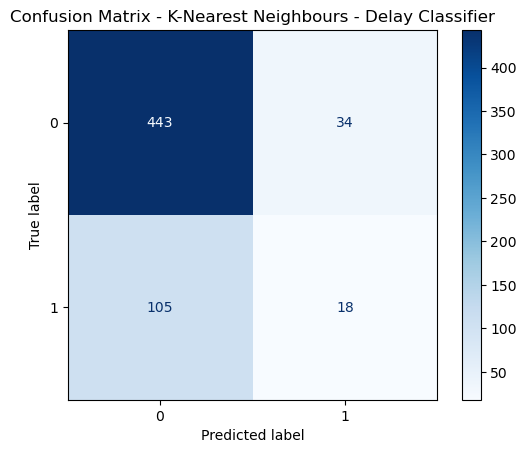

In [190]:
confusion_matrix_display =  ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred), display_labels=knn.classes_)
target_names = ["No Delay", "Delay"]
confusion_matrix_display.plot(cmap="Blues")
plt.title("Confusion Matrix - K-Nearest Neighbours - Delay Classifier")
plt.show()

##### Accuracy

Lets see how accurate the KNN model is.

In [191]:
accuracy = accuracy_score(y_test,y_pred)
print(f"Accuracy Score:", accuracy)

Accuracy Score: 0.7683333333333333


##### Cross Validation to Get the Best Value of K

In [192]:
k_values = range(1, 21)
cv_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5)
    cv_scores.append(scores.mean())

optimal_k = k_values[np.argmax(cv_scores)]
print("Best K =", optimal_k)

Best K = 20


##### Plot Cross Validation Scores

Text(0.5, 1.0, 'Accuracy Scores for Different Number of Nearest Neighbours')

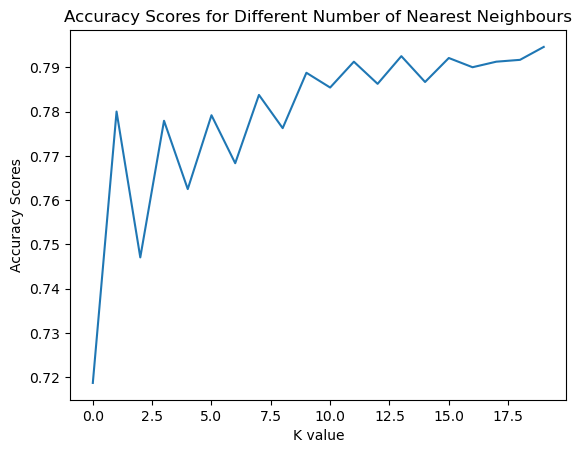

In [193]:
plt.figure()
plt.plot(cv_scores)
plt.ylabel("Accuracy Scores")
plt.xlabel("K value")
plt.title("Accuracy Scores for Different Number of Nearest Neighbours")

##### Model Re-Training

Now that we know that the model is more accurate with $K=14$ lets retrain the KNN classifier model using this new parameter.

In [194]:
# Define new KNN classifer model with K=18
knn = KNeighborsClassifier(n_neighbors=optimal_k)

# Fit the model to the training data
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=20)

##### Make New Predictions Using the New KNN Model.  

In [195]:
# Use the new KNN classifier to predict departure delays.
y_pred = knn.predict(X_test_scaled)

##### Output Metrics

In [196]:
print("----------------- Delay Classification Report -----------------")
print(classification_report(y_test, y_pred))

----------------- Delay Classification Report -----------------
              precision    recall  f1-score   support

           0       0.80      0.99      0.88       477
           1       0.43      0.02      0.05       123

    accuracy                           0.79       600
   macro avg       0.61      0.51      0.47       600
weighted avg       0.72      0.79      0.71       600



##### New Confusion Matrix 

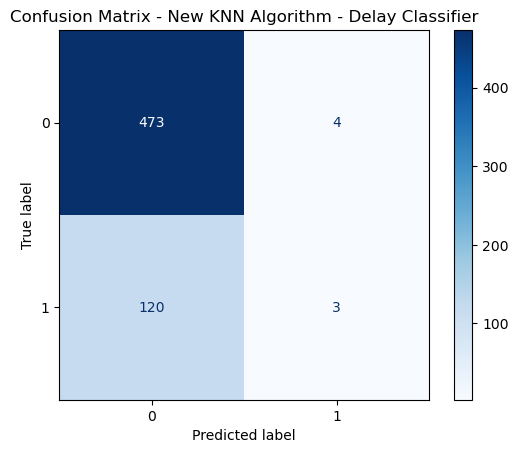

In [197]:
confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=knn.classes_)
confusion_matrix_display.plot(cmap="Blues")
plt.title("Confusion Matrix - New KNN Algorithm - Delay Classifier")
plt.show()

#### Overview

Talk about the performance of the new and old classifer, what happend, was it good at prediction delays?

#### Prediction Power

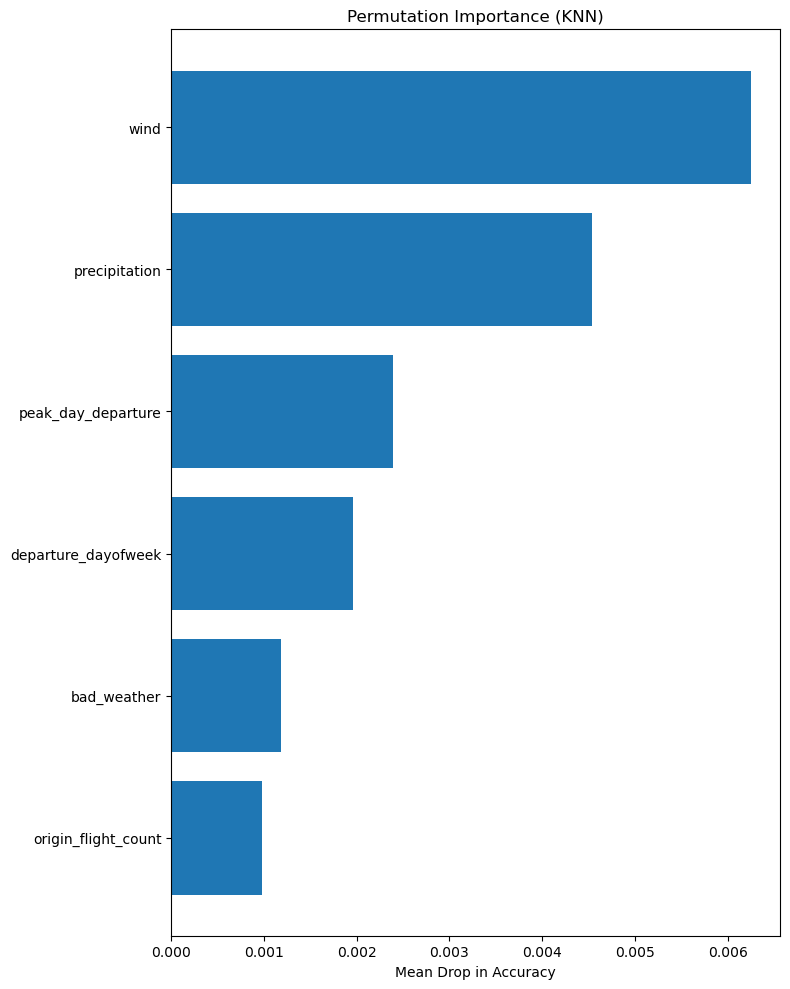

In [198]:
perm = permutation_importance(
    knn, X_train_scaled, y_train,
    n_repeats=20,
    random_state=42
)

perm_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": perm.importances_mean
}).sort_values("Importance", ascending=True)

plt.figure(figsize=(8,10))
plt.barh(perm_df["Feature"], perm_df["Importance"])
plt.xlabel("Mean Drop in Accuracy")
plt.title("Permutation Importance (KNN)")
plt.tight_layout()
plt.show()

### Classification Algorithm 3: Decision Trees Classification

**Introduction To Decision Trees**

A decision tree is a simple classification model that predicts an outcome by repeatedly splitting the data based on the most informative features. In this assignment, a decision tree can be trained on flight schedule and weather variables to classify flights as delayed or not delayed. The model learns rules such as “if wind is high and precipitation is high, predict delayed,” making it well suited for capturing non-linear relationships between conditions and delays. Because decision trees are easy to understand and handle both numerical and categorical data, they provide a clear baseline classifier and useful insights into which features contribute most to predicting flight delays.

Using sklearn it is possible to implement a decision tree classifier model in a similiar way to the regression and nearest neighbour models used previously.

#### Define Features

In [208]:
# Define features to be used in the decision tree classifier.
feature_columns = [
    "distance_km",
    "flight_duration_mins",
    "wind",
    "precipitation",
    "bad_weather"
]

#### Define Features and Target Variable

In [209]:
# Define X as a dataframe containing the features 
X = flight_info_df[feature_columns]

# Define y as a dataframe containing the target variable.
y = flight_info_df["delayed"]

#### Split Data

In [210]:
# Create and 80/20 train, test split.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

#### Train the Decision Tree Model

In [211]:
# Define a Decision Tree Model
dt = DecisionTreeClassifier(
    criterion="gini",     # or "entropy"
    max_depth=None,       # allow full depth
    random_state=42
)

# Fit the model to the training data.
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

#### Make Prediction using the Test Data

In [212]:
# Use the Decision Tree classifier to predict departure delays
y_pred = dt.predict(X_test)

#### Model Evaluation

Since the Decision Tree model is used for classification, lets use the same maetric as the Logistical Regression and KNN models namely:
- Precision
- Recall
- f1-Score
- Support
- Confusion Matrix
- Accuracy

##### Classification Report

In [213]:
# Output Model Evaluation Metrics precision, recall, f1-score, support and, accuracy. 
print("----------------- Delay Classification Report -----------------")
print(classification_report(y_test, y_pred))

----------------- Delay Classification Report -----------------
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       477
           1       0.24      0.20      0.21       123

    accuracy                           0.71       600
   macro avg       0.52      0.52      0.52       600
weighted avg       0.69      0.71      0.70       600



##### Confusion Matrix

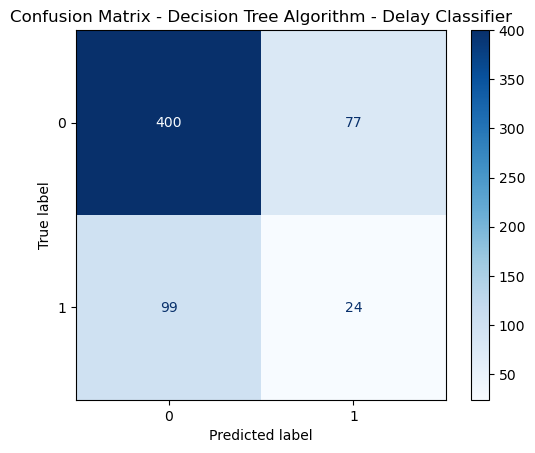

In [214]:
# Ourput the confusion matrix of the Decision Tree Model
confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=dt.classes_)
confusion_matrix_display.plot(cmap="Blues")
plt.title("Confusion Matrix - Decision Tree Algorithm - Delay Classifier")
plt.show()

#### Decision Tree Model Overview

Discussion about how the model perform, what it did well, what it didn't do well ....

#### Predictive Feature Analysis

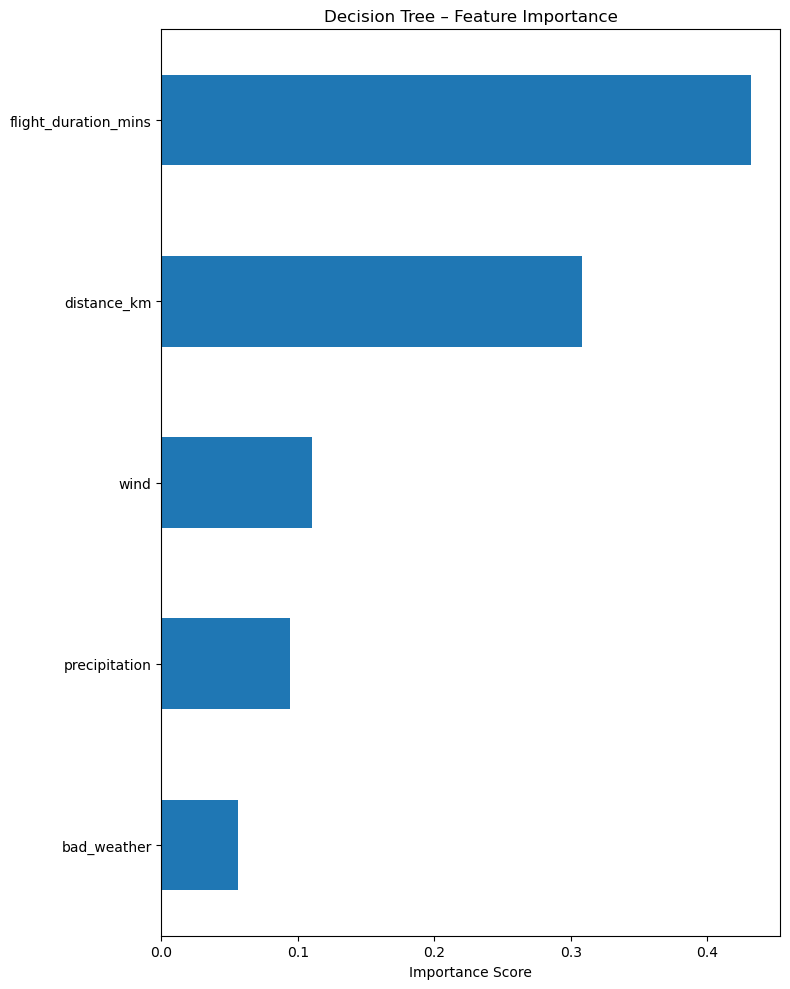

In [215]:
# Store and sort importances
dt_importance = pd.Series(dt.feature_importances_, index=X.columns).sort_values()

plt.figure(figsize=(8, 10))
dt_importance.plot(kind="barh")
plt.title("Decision Tree – Feature Importance")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

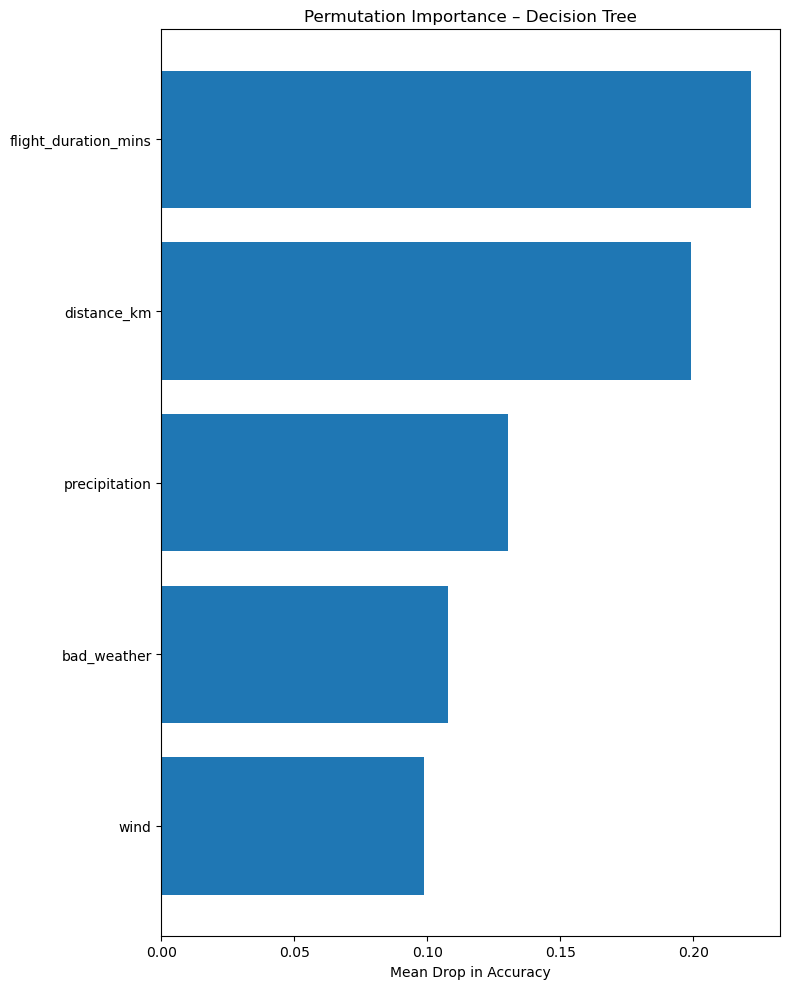

In [216]:
perm_dt = permutation_importance(
    dt, X_train, y_train,
    n_repeats=20,
    random_state=42
)

perm_dt_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": perm_dt.importances_mean
}).sort_values("Importance", ascending=True)

plt.figure(figsize=(8, 10))
plt.barh(perm_dt_df["Feature"], perm_dt_df["Importance"])
plt.title("Permutation Importance – Decision Tree")
plt.xlabel("Mean Drop in Accuracy")
plt.tight_layout()
plt.show()